# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "guillaume"
ln1 = "philippe"
fn2 = "max"
ln2 = "wu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_philippe_guillaume_and_wu_max.ipynb


In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
  $$\hat w \in \mathrm{arg \, min \,} \frac 12 \vert Aw - b \vert ^2$$

<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code 
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [ ]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [ ]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += 1 / lips_const[j] * np.dot(A[:, j].T, residuals)
        # update residuals:
        residuals += A[:,j].T.dot(old_w_j - w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.sum(A * A, axis=0)
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= 1 / lips_const[j] * gradient[j] 
        # update gradient:
        gradient  -= gram[:,j] * (old_w_j - w[j])
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

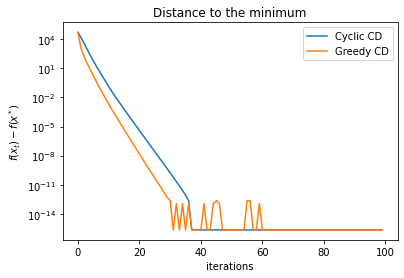

In [ ]:
eps = np.finfo("float").eps

# Find a precise minimum
x = np.linalg.solve(A.T @ A, A.T @ b)

x_solve = 0.5 * norm(A.dot(x) - b) ** 2

iter=100 * n_features
w_cyclic, objs_cyclic = cyclic_cd(A, b, n_iter=iter)
w_greedy, objs_greedy = greedy_cd(A, b, n_iter=iter)

plt.figure()
plt.title("Distance to the minimum")
plt.semilogy(np.maximum(objs_cyclic - x_solve, eps), label="Cyclic CD")
plt.semilogy(np.maximum(objs_greedy - x_solve, eps), label="Greedy CD")
plt.xlabel("iterations")
plt.ylabel("$f(x_t) - f(x^*)$")
plt.legend()
plt.show()



*   Comparison of cyclic and greedy CD as function of iterations : the cyclic and greedy CD both reach the same minimizer. The greedy reaches the minimizer with around 10 iterations earlier because it tries to converge toward the direction (feature) with the highest gradient (better than going toward a direction randomly in average). 
*   Greedy CD for L2 (Ridge) regularized logistic regression with 100,000 features : This method requires to compute the complete gradient which means that determining the direction with the highest gradient value is very costly each iteration. This method would lead to poorer performances than cyclic CD as the number of features grow, which makes it unconvenient for practical cases.

*   Greedy CD for L2 (Ridge) regularized OLS with 100,000 features : Again, the need to compute the complete gradient and determining the direction which has the highest gradient is heavy in term of time complexity, leading to $O(p^2)$ time complexity ($O(p)$ to determine the best gradient direction multiplied by $p$ iterations) where $p$ is the number of features.



## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: 
  $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

**Answer**

Let $$F = f+g$$ where $f(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) $, $g(w) = \lambda \Vert w \Vert_1 $

The gradient of $f$ is given by $$\nabla f(w) = \sum_{i=1}^{n} \frac{-y_i x_i}{1+e^{y_i w^\top x_i}} $$. 

The sub gradient of $g$ is given by $\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1) \times \dots \times \partial \vert \cdot \vert (w_p)$.


We have $$\partial F(w) = \nabla f(w) + \lambda \partial \Vert \cdot \Vert_1(w)$$


Then the equivalence $$\hat w = 0  \Leftrightarrow 0 \in \partial F(0) $$
where 
$$\partial F(0) = \nabla f(0) + \lambda \partial \Vert \cdot \Vert_1(0) $$

When $w_j = 0$, we have $\partial \vert \cdot \vert (w_j) = [-1, 1]$. As consequence, we have $\partial \Vert . \Vert_1 (0)$ equal to $n$ times the cartesian product of $[-1,1]$.

$$\partial \Vert . \Vert_1 (0) = [-1, 1]^n$$

We can replace $\partial \Vert . \Vert_1 (0)$,
$$\partial F(0) = \frac{1}{2}\sum_{i=1}^{n} -y_i x_i + \lambda[-1,1]^n $$

In matrix form, $$\partial F(0) = - \frac{1}{2} X^{\top}y + \lambda[-1,1]^n $$



becomes 
$$\hat w = 0  \Leftrightarrow \frac{1}{2} X^{\top}y\in [-\lambda, \lambda]^n$$

which remains true if $ \lambda \geq \lambda_{max} = \frac{1}{2}\Vert X^{\top}y\Vert_∞$

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, 
  $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

**Answer**

The gradient of $f$ w.r.t $w$ is given by : 
$$\nabla f(w) = \sum_{i=1}^{n} \frac{-y_i x_i}{1+e^{y_i w^\top x_i}} $$

Therefore, the hessian of $f$ w.r.t $w$ is given by : $$\nabla^2 f(w) = \sum_{i=1}^{n} \frac{y_i^2 x_i^2 e^{y_i w^\top x_i} }{(1+e^{y_i w^\top x_i})^2} $$

Let us notice that $\forall x \in \mathbb{R}, f(x) = \frac{x}{(1+x)^2} \leq \frac{1}{4}$, $\sum_{i=1}^{n} y_i^2 x_i^2 =\Vert X \Vert^2$ and  ($y_i^2 = 1$) so it is safe to take $\gamma_j$ as $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [ ]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    

    all_objs = np.zeros(n_iter)
    # TODO
    lips_const = (X.T@X/4).diagonal()
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = - np.sum(y * X[:, j] * sigmoid(- y * Xw))
            w[j] = soft_thresh(old_w_j - 1/lips_const[j] * grad_j, lamb/lips_const[j])
            
            if old_w_j != w[j]:
                Xw += X[:, j] * (w[j] - old_w_j)
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [ ]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [ ]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [ ]:
def grad_logreg(w, X, y, n_samples):
  y_exp = np.expand_dims(y, 1)
  return - y * X.T @ sigmoid(- y_exp * X @ w)

def ista_logreg(X, y, lambd, n_iter):
  n_samples, n_features = X.shape
  w = np.zeros(n_features)
  all_objs = np.zeros(n_iter)

  lipst_const = np.linalg.norm(X, ord=2) ** 2 / 4

  for t in range(n_iter):
    w = soft_thresh(w - grad_logreg(w, X, y, n_samples) / lipst_const, lambd / lipst_const)

    all_objs[t] = np.log(1. + np.exp(-y * X.dot(w))).sum() + lambd * norm(w, ord=1)
  return w, all_objs

In [ ]:
# Find a precise minimum
iter=5000
w_best, objs_logreg = ista_logreg(X, y, lambd, n_iter=iter)
obj_best = objs_logreg[-1]

In [ ]:
# Run ISTA and Prox CD
iter=100
w_ista_logreg, objs_ista_logreg = ista_logreg(X, y, lambd, n_iter=iter)
w_cd_logreg, objs_cd_logreg = cd_logreg(X, y, lambd, n_iter=iter)

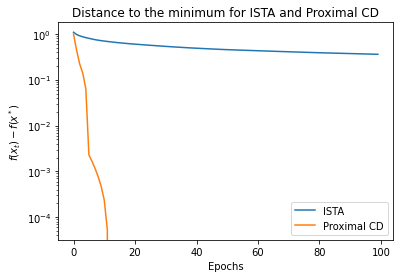

In [ ]:
plt.figure()
plt.semilogy(objs_ista_logreg - obj_best, label="ISTA")
plt.semilogy(objs_cd_logreg - obj_best, label="Proximal CD")
plt.title("Distance to the minimum for ISTA and Proximal CD")
plt.xlabel("Epochs")
plt.ylabel("$f(x_t) - f(x^*)$")
plt.legend()
plt.show()

* We first computed a good approximation of the minimizer using the CD for the logistic regression case (5,000 iterations). 

* Once we have a good approximation of the minimizer, we can plot the distance to the minimum of the 2 methods. Proximal CD converges faster than ISTA. The leukemia dataset contains 7129 features and only 72 samples. In this case of high number of features, one step of Proximal CD takes 1 feature and 72 samples and we are in a case with higher number of samples than feature. Moreover, this also explains the poor convergence of ISTA.

* The Lasso regularization brings sparsity over time, which makes it slow in the beginning but linear until the end, thus explaining the two different slopes observed on the plot above. If we look at the stem plot of $w$ below, we see a lot of zeros except for some features. We print the name of the features nonzero.

* Also, it is important to remark that the x-axis of the plot is the number of epochs. For ISTA, the number of epochs and iterations are the same. However, for Proximal CD, one epoch corresponds to the number of features iterations. Fortunately, each iteration concerns only one feature of the dataset, so iteration are lighter.

In [ ]:
# features nonzero
leuk.data.columns[np.where(w_cd_logreg != 0)]

Index(['HG3549-HT3751_at', 'M27891_at', 'M14483_rna1_s_at'], dtype='object')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


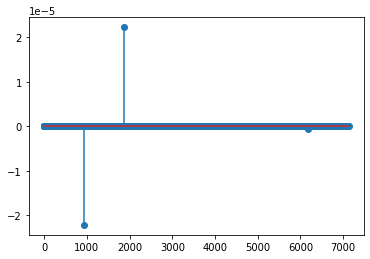

In [ ]:
plt.figure()
plt.stem(w_cd_logreg)
plt.show()